# BINARY CLASSIFICATION

---

**Overview:**
The 2024 Kaggle Playground Series is hosting a competition focused on binary classification, where participants must predict whether mushrooms are edible or poisonous based on their physical characteristics.

**Objective:**
Predict whether each mushroom in the test set is edible ('e') or poisonous ('p').

**Evaluation Metric:**
Submissions are evaluated using the Matthews correlation coefficient (MCC).

**Submission Requirements:**
- Each submission file should include a header and follow this format:
  ```
  id,class
  3116945,e
  3116946,p
  3116947,e
  ```

**Timeline:**
- **Start Date:** August 1, 2024
- **Final Submission Deadline:** August 31, 2024
- All deadlines are at 11:59 PM UTC unless otherwise noted.

**Competition Details:**
- The Tabular Playground Series aims to offer engaging and approachable datasets to help participants practice machine learning skills.
- The datasets used are synthetically generated, closely resembling real-world data, but with some additional categorical values and artifacts.
- Competitors may use the original UCI Mushroom dataset for comparison and model enhancement.

**Files Provided:**
- **train.csv:** Contains training data with binary target labels ('e' or 'p').
- **test.csv:** Contains test data for which predictions are to be made.
- **sample_submission.csv:** Provides the required format for submissions.

This competition provides an opportunity to experiment with model and feature engineering techniques using synthetic data, allowing for rapid iteration and learning.

---


In [1]:
!pip install -q ucimlrepo

## IMPORT LIBRARIES

In [2]:
# Import the numpy library and assign it the alias np for numerical operations and array manipulations
import numpy as np

# Import the pandas library and assign it the alias pd for data manipulation and analysis
import pandas as pd

# Import the matplotlib.pyplot library and assign it the alias plt for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# Import the seaborn library and assign it the alias sns for statistical data visualization
import seaborn as sns

# Import the re library for regular expression operations
import re

# Import the warnings library to manage and filter warnings
import warnings

# Import the clone function from sklearn.base for creating copies of estimators
from sklearn.base import clone

# Import fetch_ucirepo from ucimlrepo to fetch datasets from the UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo 

# Import the XGBClassifier from xgboost for gradient boosting classification
from xgboost import XGBClassifier

# Import the pickle library for serializing and deserializing Python objects
import pickle

# Import the garbage collection (gc) library for memory management and cleanup
import gc

# Import LinearSegmentedColormap from matplotlib.colors for creating custom color maps
from matplotlib.colors import LinearSegmentedColormap

# Import the LGBMClassifier from lightgbm for LightGBM gradient boosting classification
from lightgbm import LGBMClassifier

# Import CatBoostClassifier and Pool from catboost for CatBoost gradient boosting classification
from catboost import CatBoostClassifier, Pool

# Import early_stopping and log_evaluation callbacks from lightgbm for monitoring training
from lightgbm.callback import early_stopping, log_evaluation

# Import matthews_corrcoef from sklearn.metrics for calculating the Matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef

# Import mode from scipy.stats for computing the mode of a dataset
from scipy.stats import mode

# Suppress warnings to avoid cluttering output with warning messages
warnings.filterwarnings("ignore")

# Import SimpleImputer from sklearn.impute for handling missing values in datasets
from sklearn.impute import SimpleImputer

# Import various functions and classes for model selection and evaluation from sklearn.model_selection
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate

# Import various metrics and tools for evaluating models from sklearn.metrics
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

# Import StandardScaler and LabelEncoder from sklearn.preprocessing for data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import ColumnTransformer and make_column_transformer from sklearn.compose for applying transformations to specific columns
from sklearn.compose import ColumnTransformer, make_column_transformer

# Import make_pipeline and Pipeline from sklearn.pipeline for creating machine learning pipelines
from sklearn.pipeline import make_pipeline, Pipeline

# Import the XGBClassifier from xgboost (already imported earlier, this line is redundant)
from xgboost import XGBClassifier


In [3]:
TARGET = 'class'
N_FOLDS = 4
SEED = 6
ES_ROUNDS = 100
ES_LOG_STEPS = 100
THRESHOLD = 0.506

## LOADING THE DATA

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col=[0])
test  = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col=[0])
original = fetch_ucirepo(id=848)['data']['original']

## CONFIGURING DATAFRAME STYLING

To improve the visual presentation of our dataset, we will configure a consistent styling setup. This approach allows us to apply uniform formatting to our data frames, enhancing both readability and aesthetics throughout our analysis. Below, we provide a demonstration of how to establish and reuse this style across the notebook.


In [5]:
def style_dataframe(df):
    """
    Applies a consistent styling to the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to style.

    Returns:
    pd.io.formats.style.Styler: The styled DataFrame.
    """
    return df.style.set_table_styles(
        [{
            'selector': 'thead th',
            'props': [
                ('background-color', '#1E90FF'),  # Dodger blue background for header
                ('color', '#FFFFFF'),  # White text for header
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('border', '1px solid #4682B4')  # Steel blue border for header
            ]
        }, {
            'selector': 'tbody td',
            'props': [
                ('background-color', '#FAFAD2'),  # Light goldenrod yellow background for cells
                ('border', '1px solid #FFD700'),  # Gold border for cells
                ('font-weight', 'bold'),
                ('color', '#000000')  # Black text for better readability
            ]
        }]
    ).set_properties(**{'text-align': 'center'}).set_table_attributes('style="width:100%;"').hide(axis='index')



## OVERVIEW DATA

In [6]:
# Select a subset (e.g., first 10 rows)
subset_train = train.loc[train.index[:10]]

# Apply styling to the subset
styled_subset_train = style_dataframe(subset_train)

# Display the styled DataFrame
styled_subset_train

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
e,8.800000,f,s,u,f,a,c,w,4.510000,15.390000,nan,nan,w,nan,nan,f,f,nan,d,a
p,4.510000,x,h,o,f,a,c,n,4.790000,6.480000,nan,y,o,nan,nan,t,z,nan,d,w
e,6.940000,f,s,b,f,x,c,w,6.850000,9.930000,nan,s,n,nan,nan,f,f,nan,l,w
e,3.880000,f,y,g,f,s,nan,g,4.160000,6.530000,nan,nan,w,nan,nan,f,f,nan,d,u
e,5.850000,x,l,w,f,d,nan,w,3.370000,8.360000,nan,nan,w,nan,nan,f,f,nan,g,a
p,4.300000,x,t,n,f,s,c,n,5.910000,8.200000,nan,nan,w,nan,n,t,z,nan,d,a
e,9.650000,p,y,w,f,e,c,k,19.070000,12.690000,nan,s,w,nan,nan,t,e,nan,g,w
p,4.550000,x,e,e,f,a,nan,y,8.310000,9.770000,nan,nan,y,nan,w,t,z,nan,d,a
p,7.360000,f,h,e,f,x,d,w,5.770000,17.130000,b,nan,w,nan,nan,f,f,nan,d,a
e,6.450000,x,t,n,f,a,d,w,7.130000,12.770000,nan,nan,e,nan,nan,f,f,nan,d,a


# EDA

## Feature Types

**Categorical Features**

**Continuous Features**


In [7]:
categorical_features = train.select_dtypes(include='object').columns.tolist()
categorical_features.remove('class')
numerical_features = train.select_dtypes(exclude='object').columns.tolist()


# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

styled_numerical_df = style_dataframe(df_numerical)
styled_numerical_df

Numerical Variables
cap-diameter
stem-height
stem-width


In [8]:
styled_categorical_df = style_dataframe(df_categorical)
styled_categorical_df

Categorical Variables
cap-shape
cap-surface
cap-color
does-bruise-or-bleed
gill-attachment
gill-spacing
gill-color
stem-root
stem-surface
stem-color



## TARGET VISUALIZATION


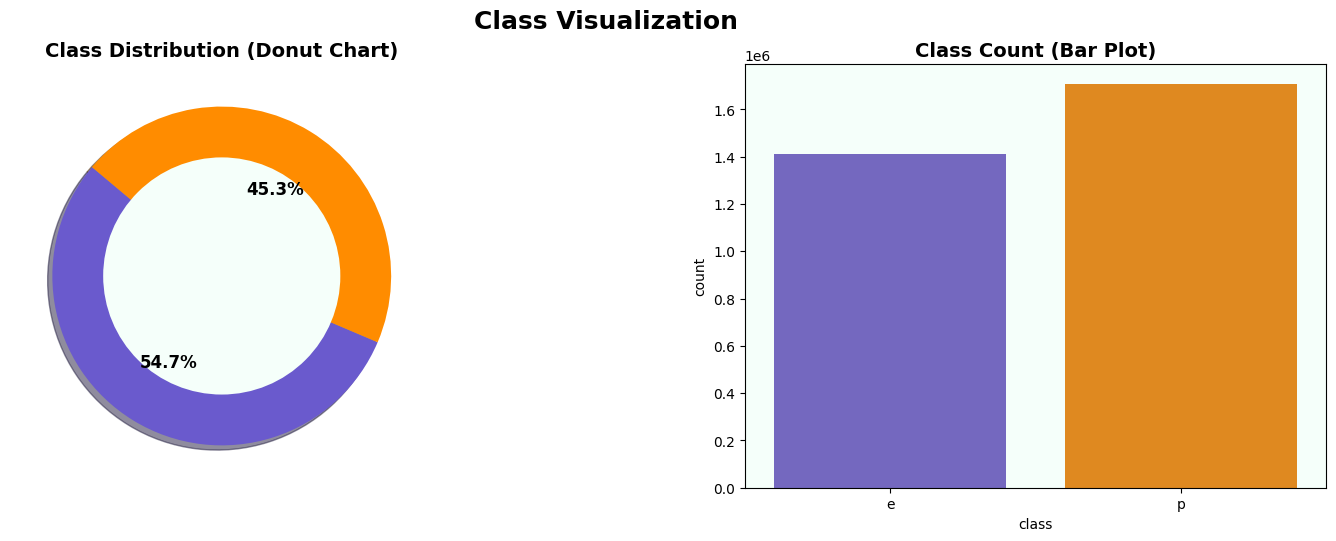

In [9]:
# Custom color palette specifically for the 'class' column
class_palette = sns.color_palette(['#6A5ACD', '#FF8C00'])  # Using Slate Blue and Dark Orange to represent classes

# Plotting the 'class' variable
f, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Donut chart for 'class' distribution
wedges, texts, autotexts = ax[0].pie(train['class'].value_counts(), autopct='%1.1f%%', shadow=True, colors=class_palette, startangle=140, wedgeprops=dict(width=0.4))
ax[0].set_ylabel('')
ax[0].set_title(f'Class Distribution (Donut Chart)', fontsize=14, fontweight='bold')
ax[0].set_facecolor('#F5FFFA')
center_circle = plt.Circle((0, 0), 0.70, fc='#F5FFFA')  # Adding a circle at the center to create the donut
ax[0].add_artist(center_circle)

# Set label and percentage text colors to black
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')  # Change label text color to black
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')  # Change percentage text color to black
    autotext.set_weight('bold')

# Bar plot for 'class' distribution
sns.countplot(x='class', data=train, ax=ax[1], palette=class_palette)
ax[1].set_title(f'Class Count (Bar Plot)', fontsize=14, fontweight='bold')
ax[1].set_facecolor('#F5FFFA')

plt.suptitle(f'Class Visualization', fontsize=18, fontweight='bold')
plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
plt.show()


## DATA VISUALIZATION

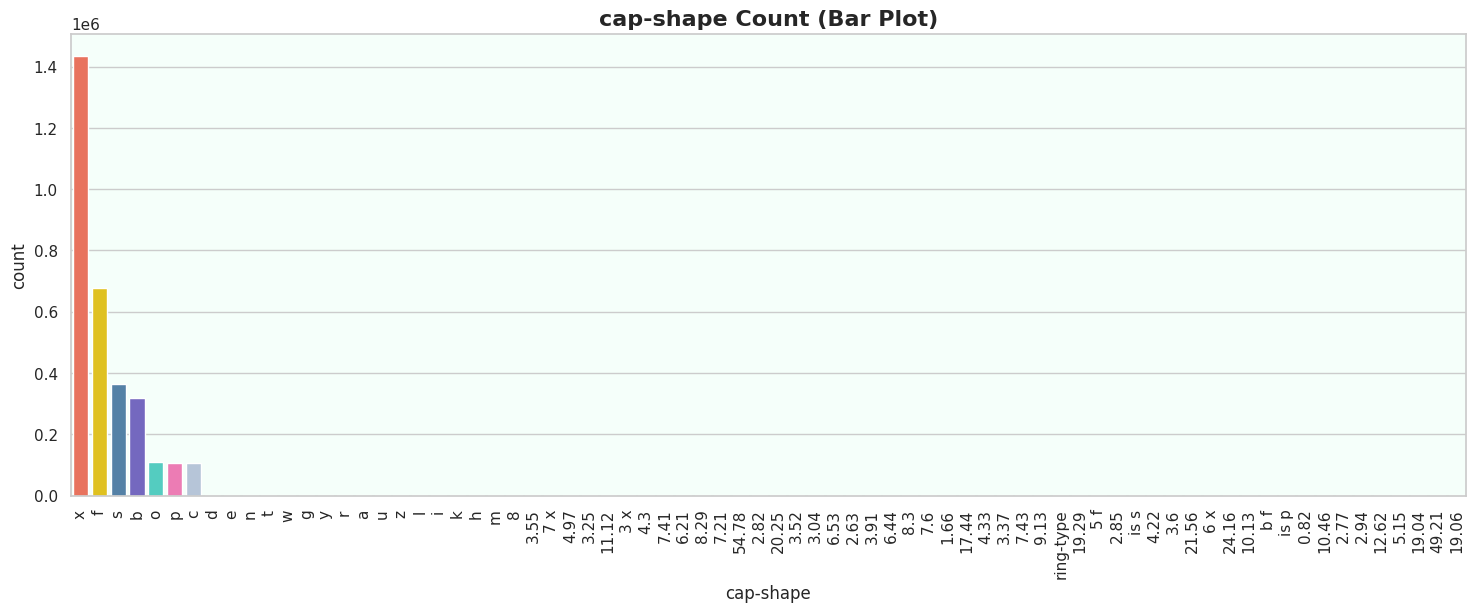

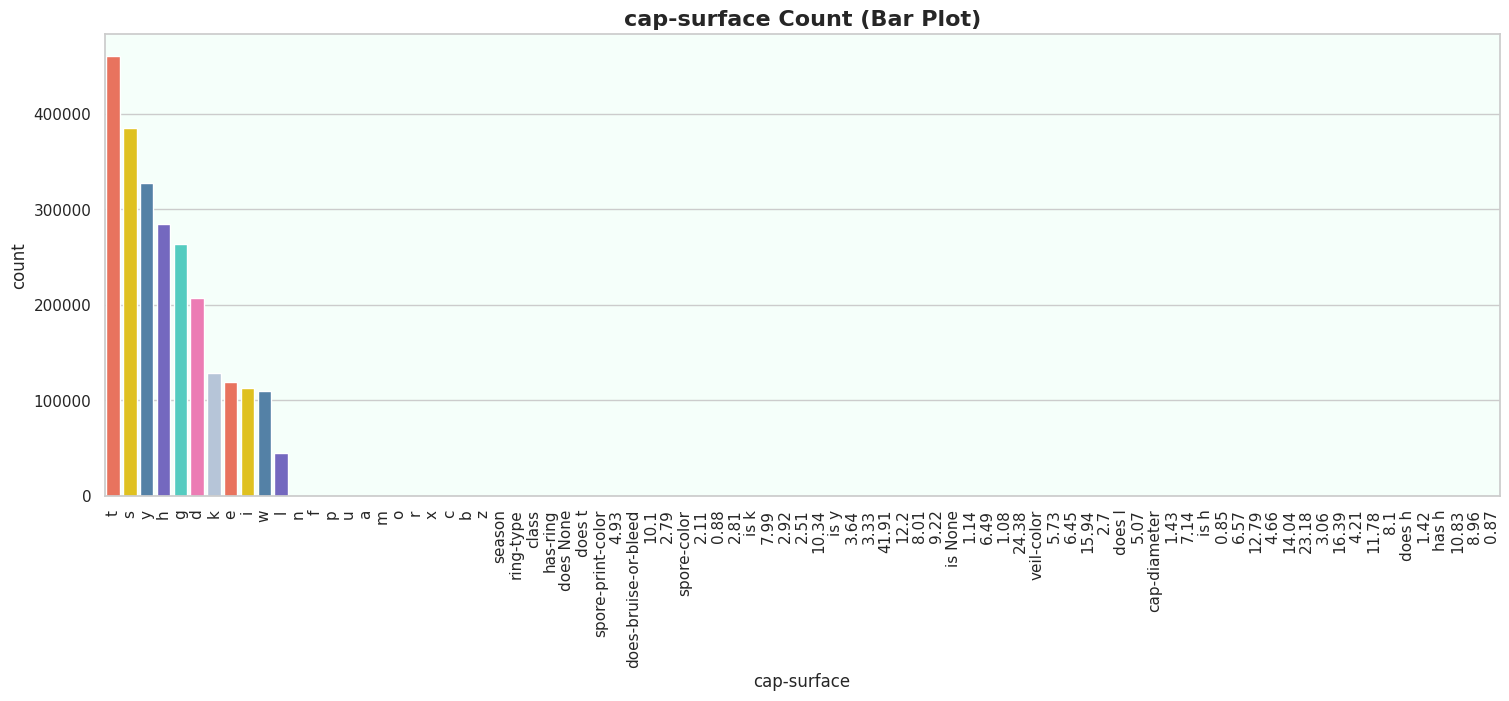

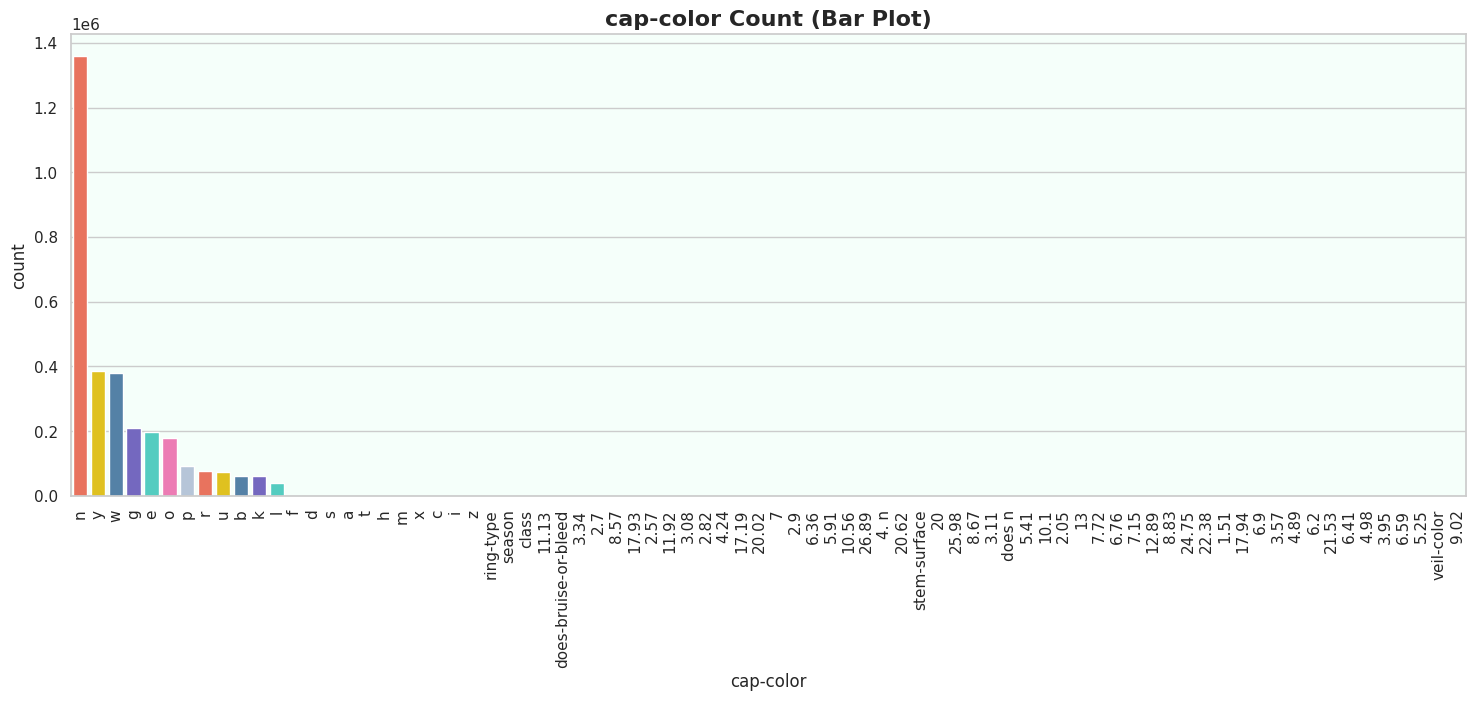

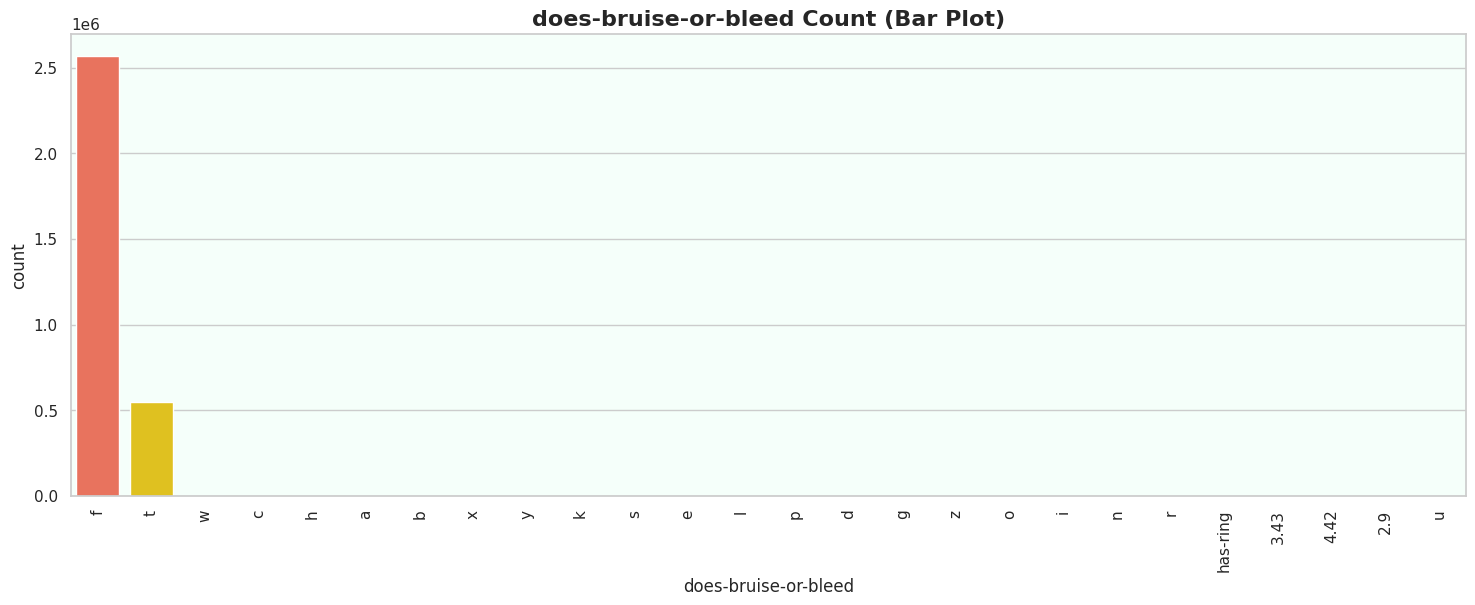

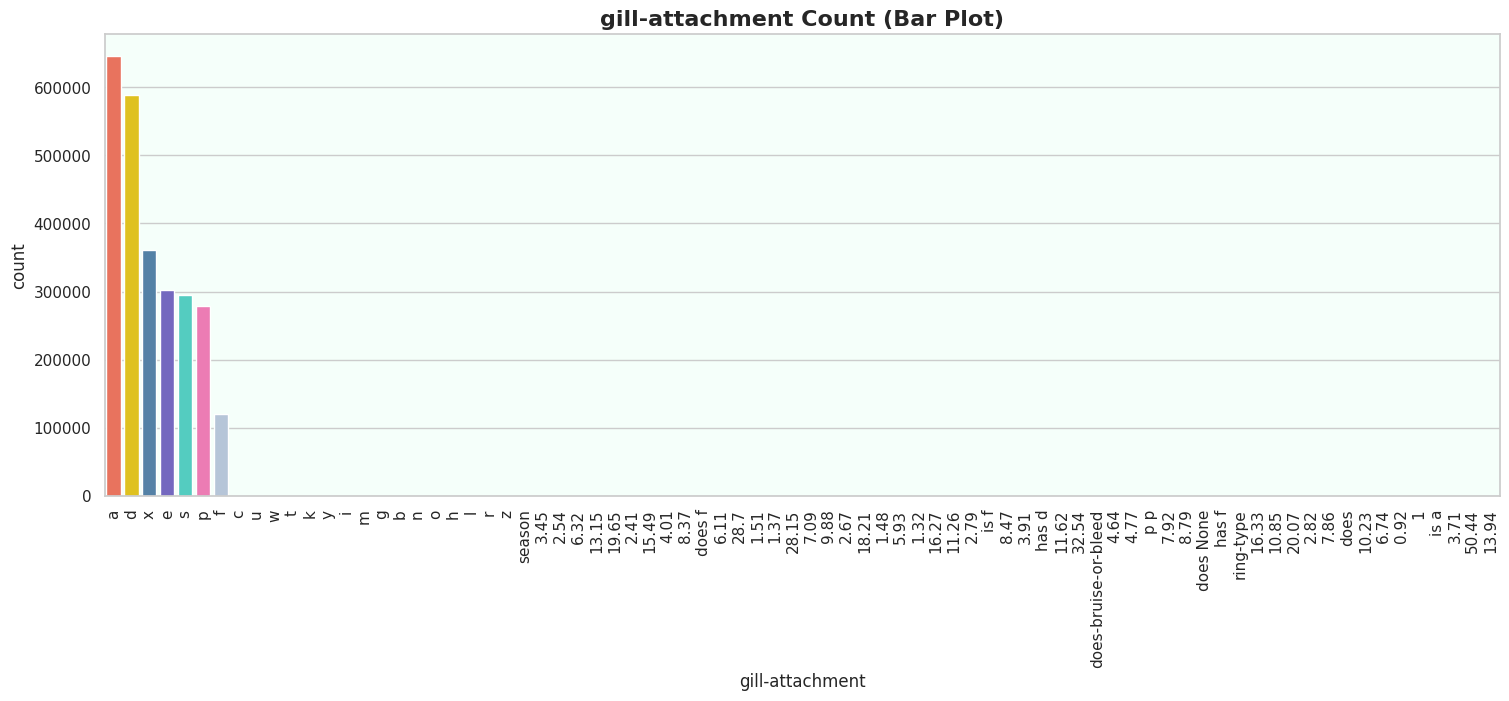

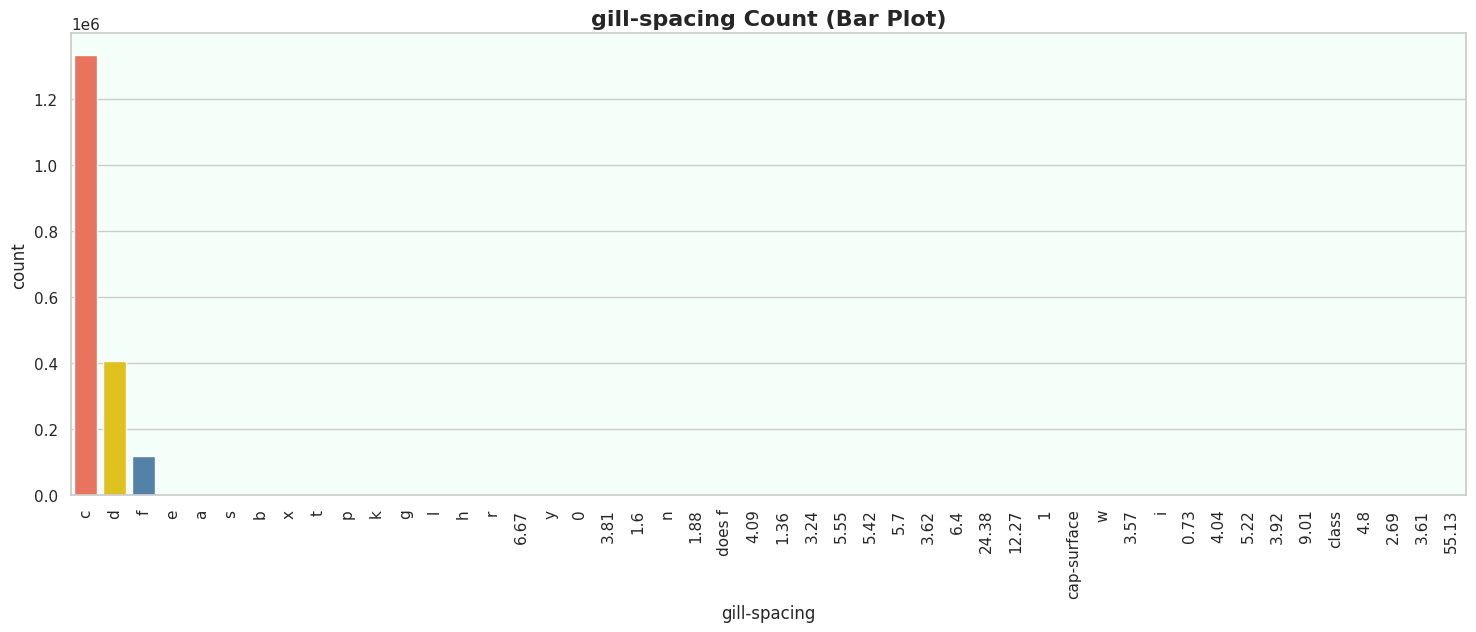

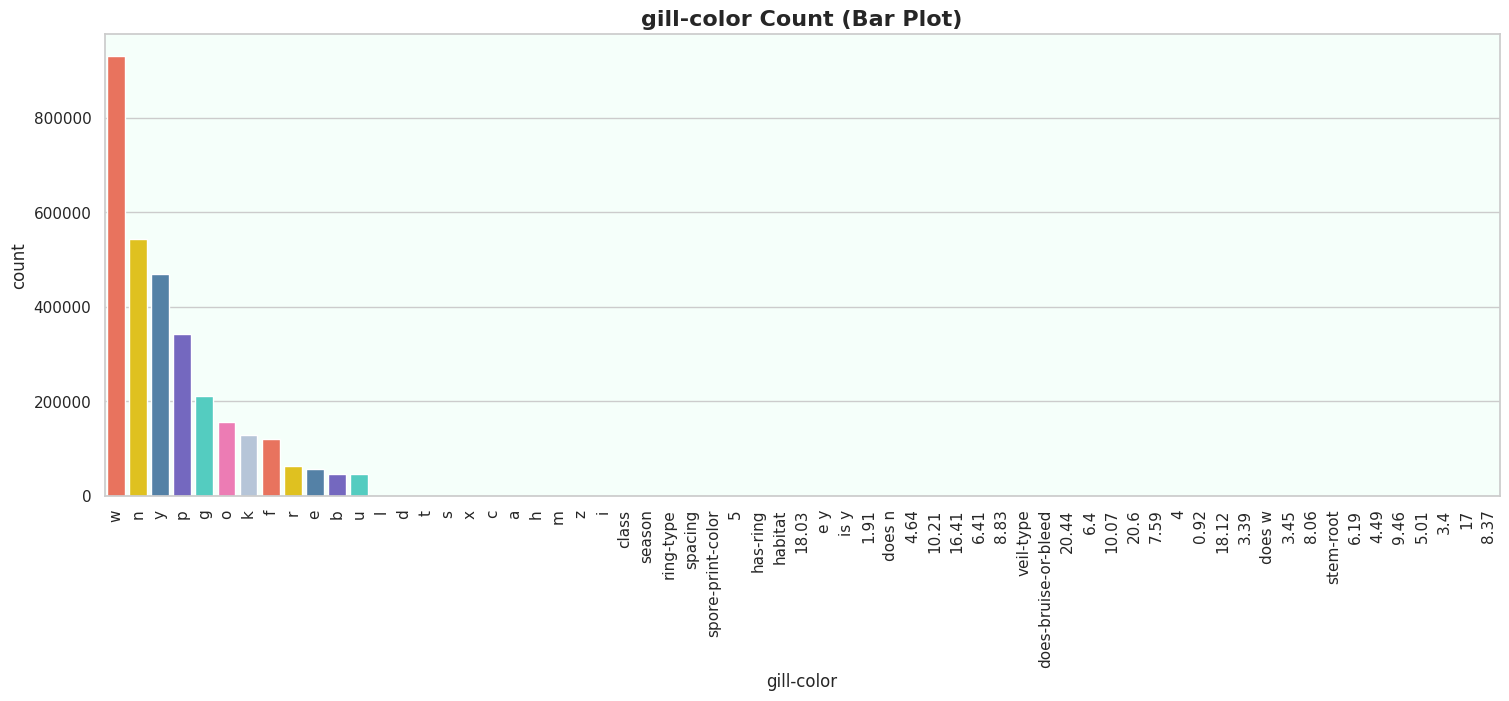

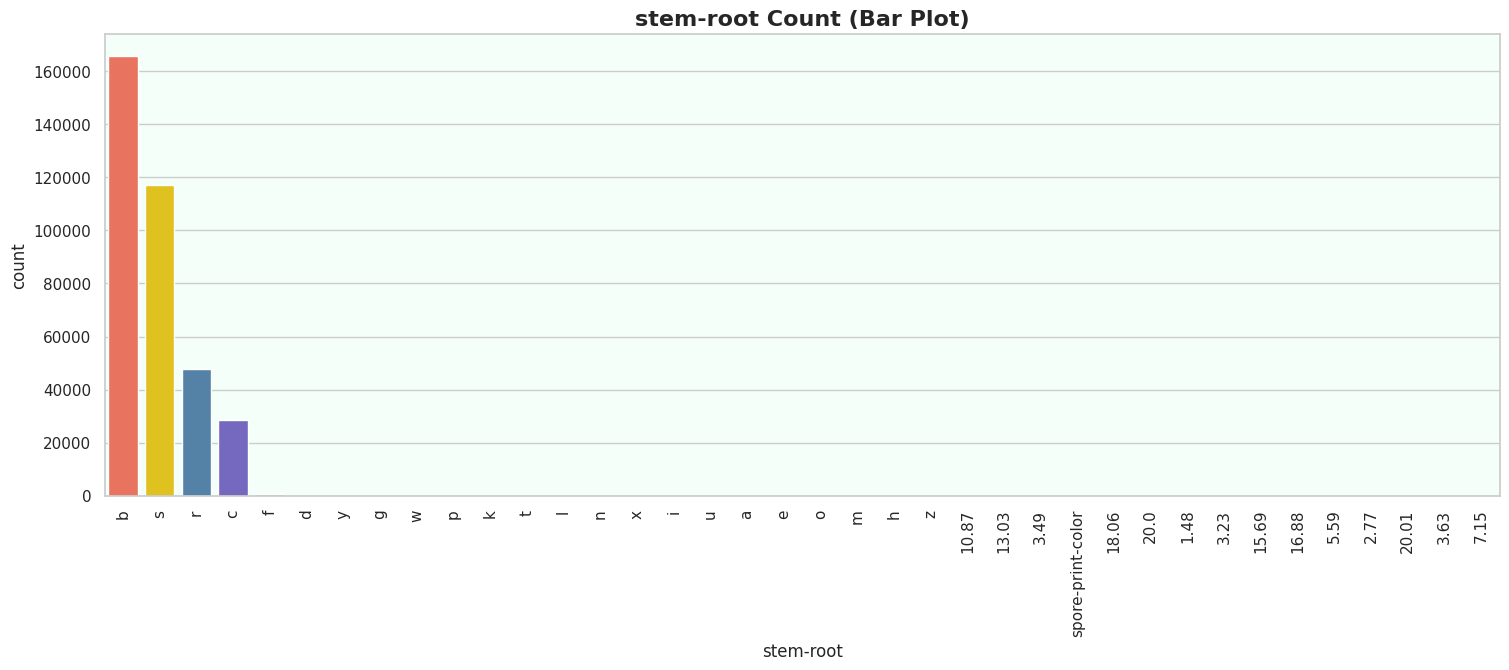

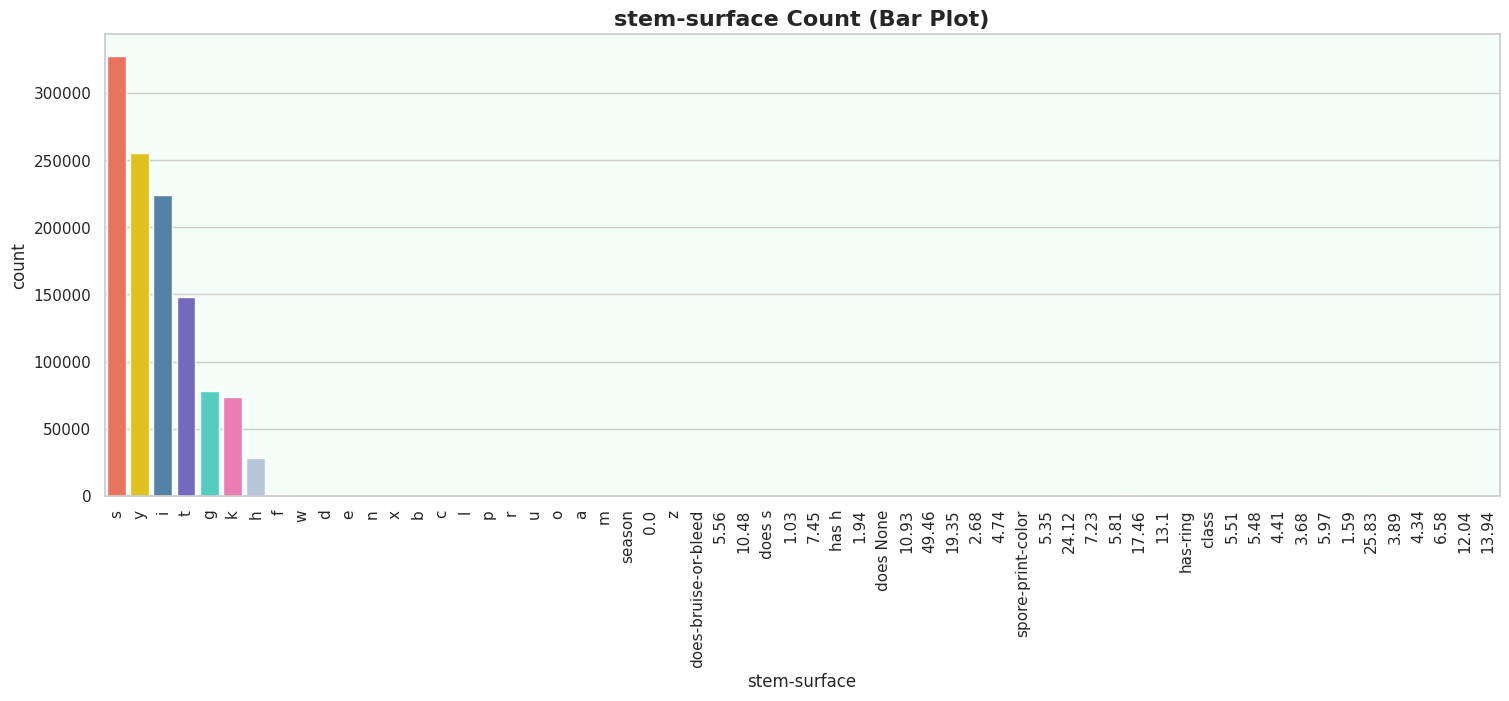

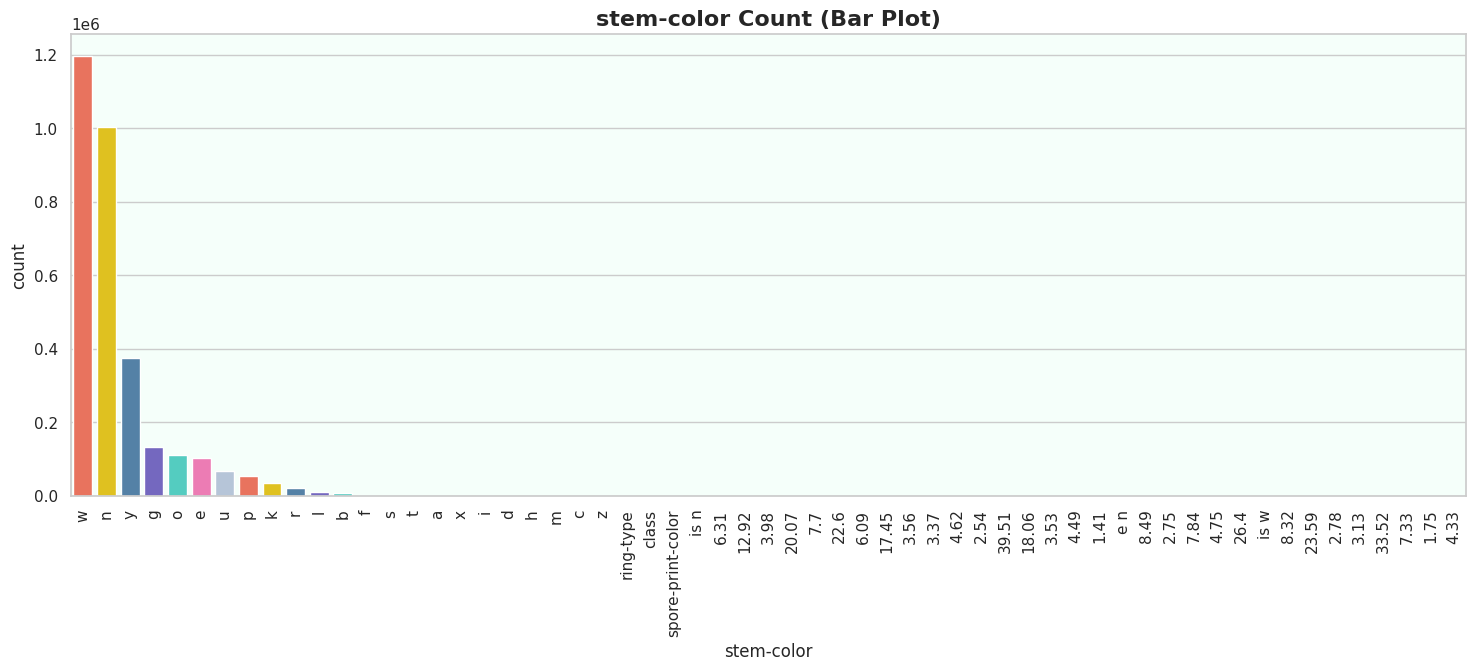

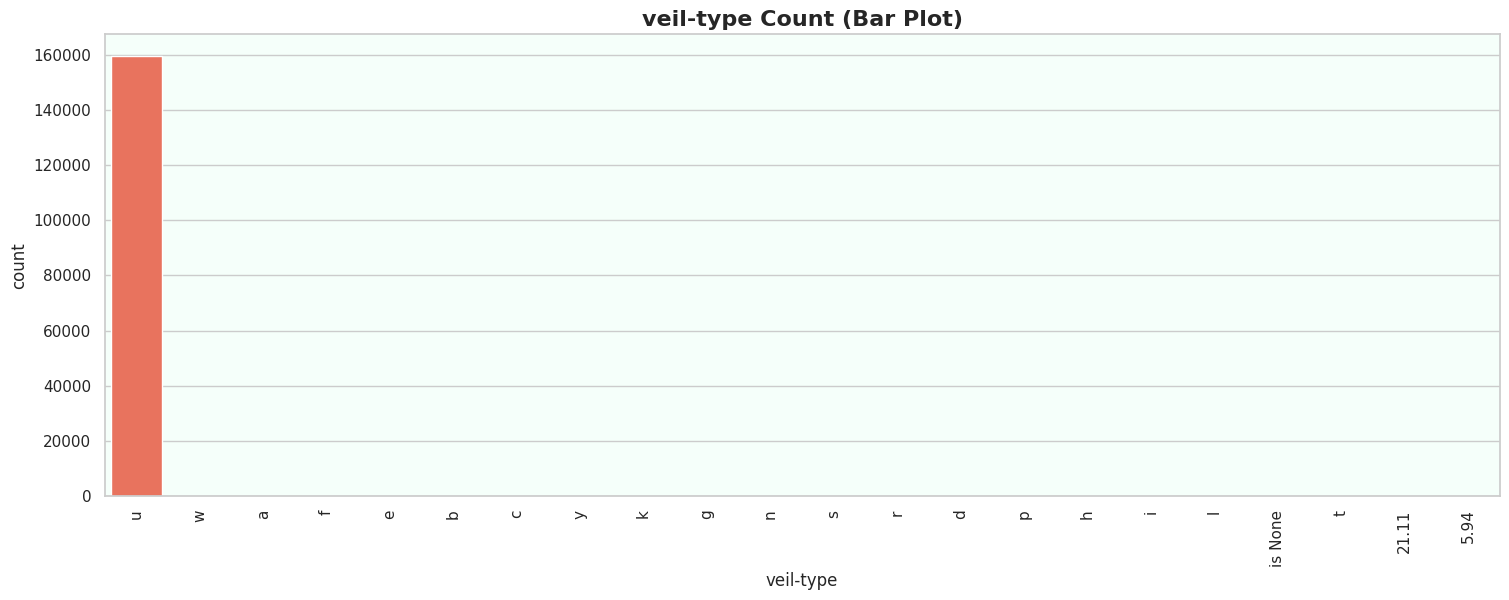

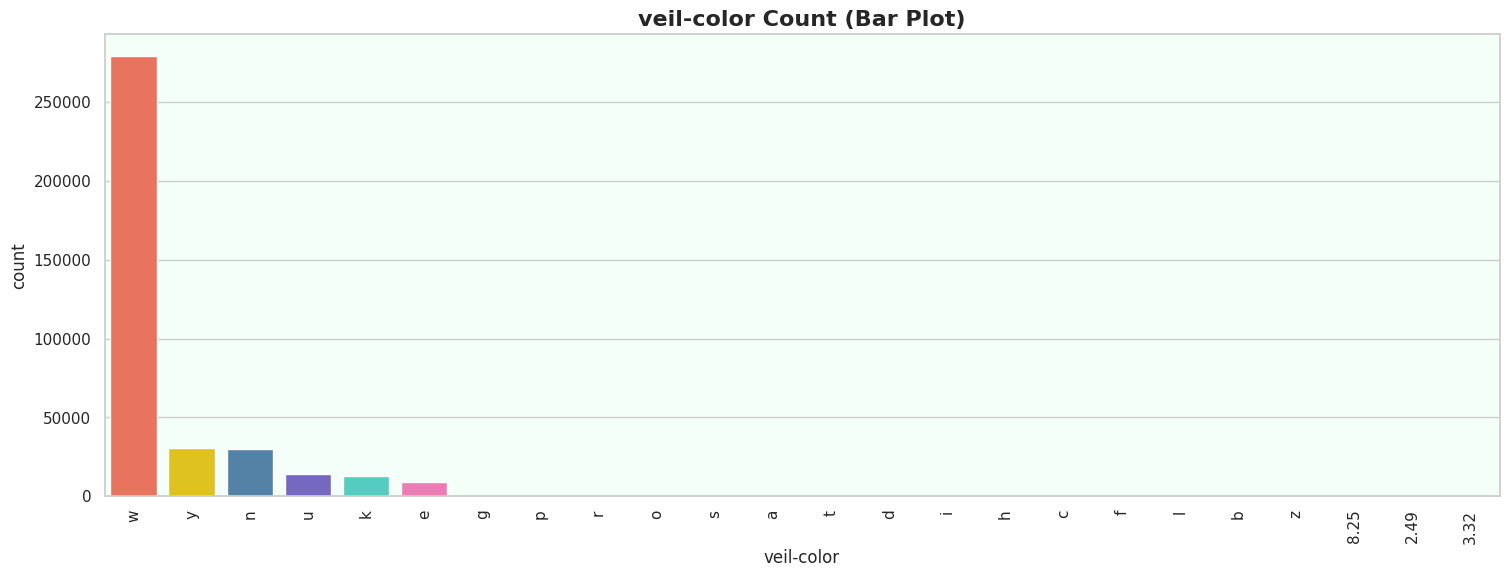

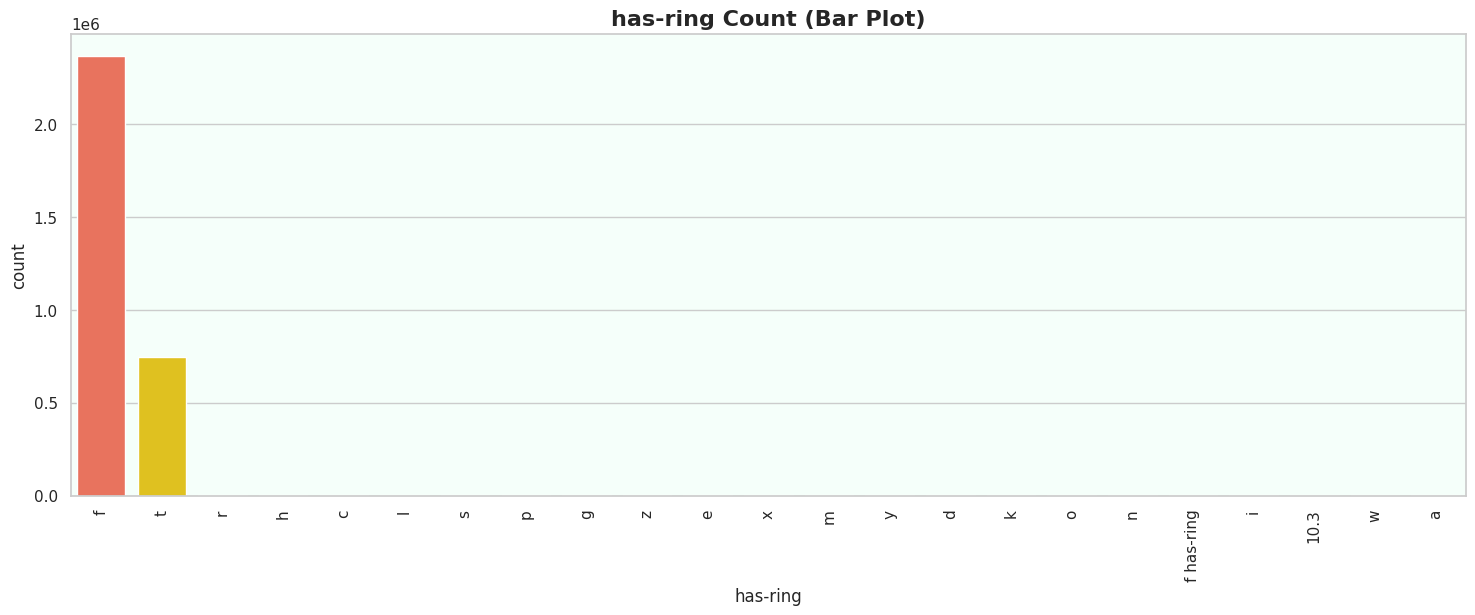

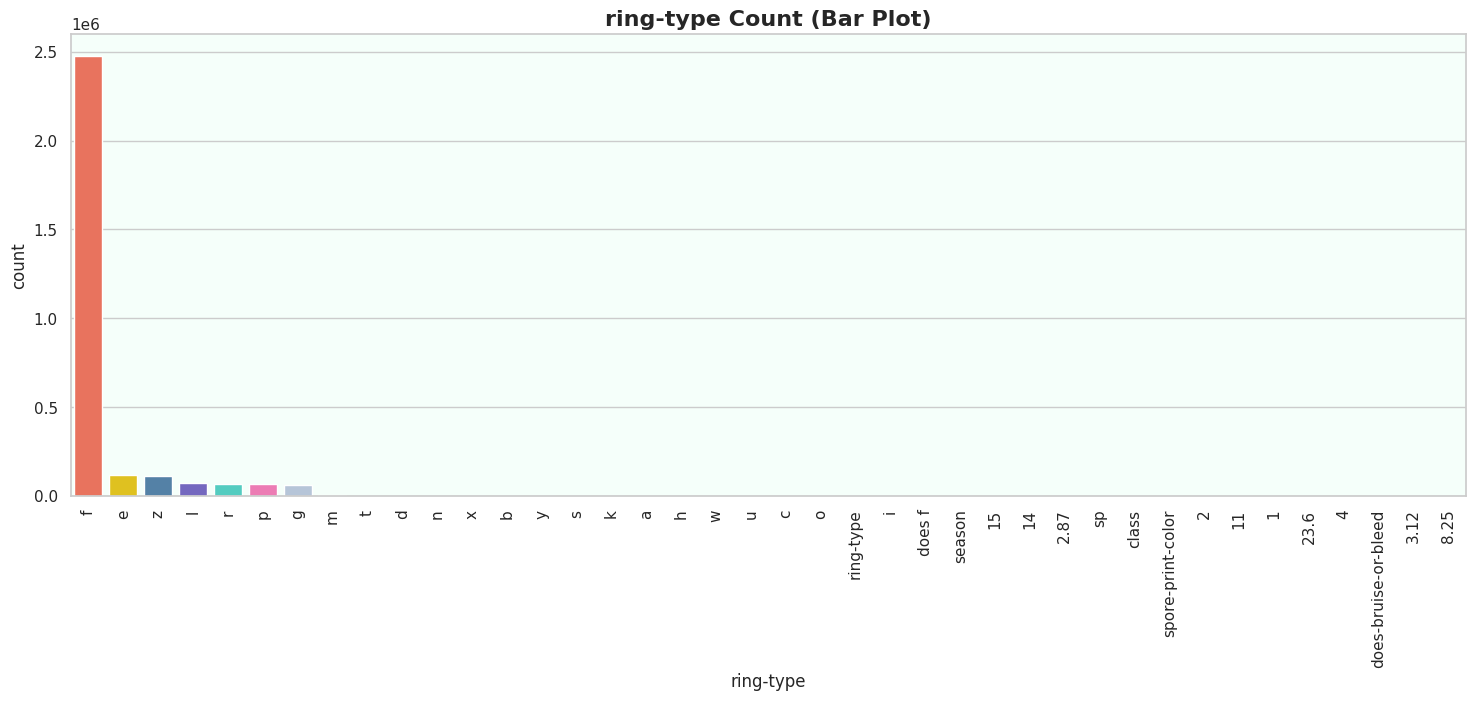

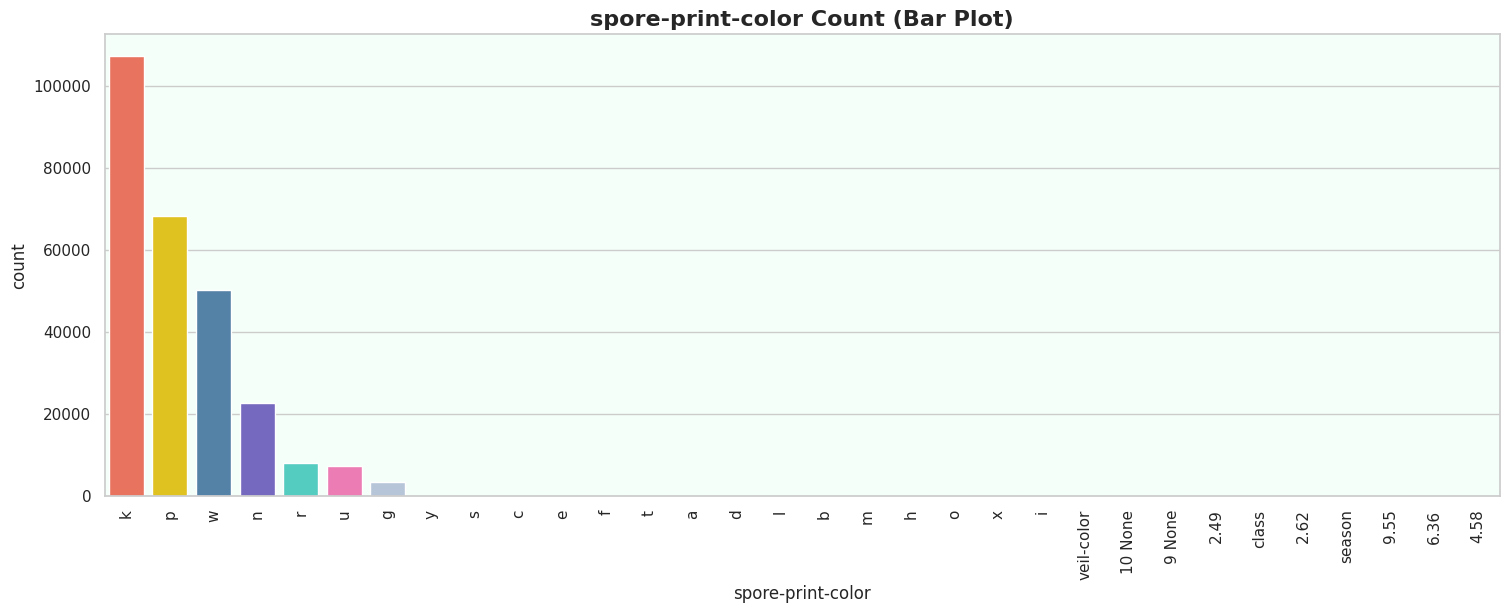

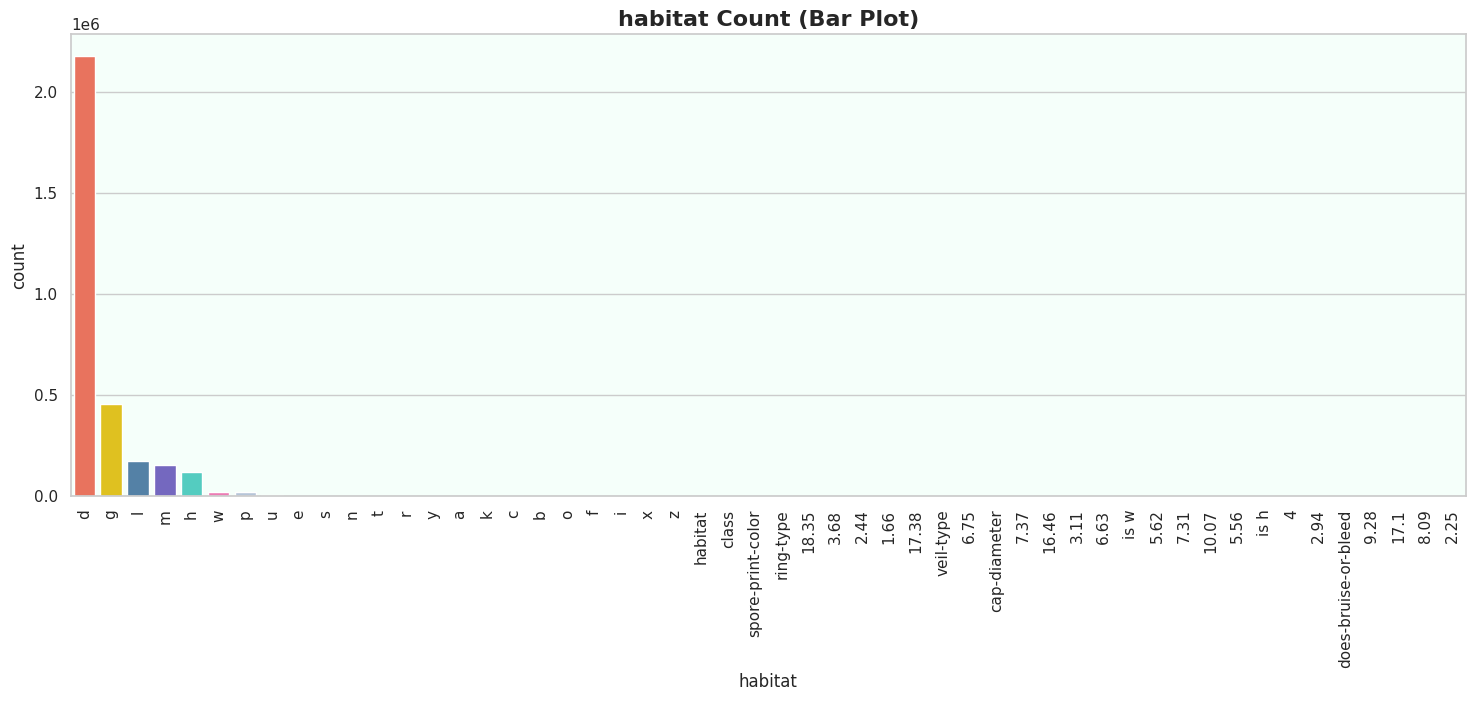

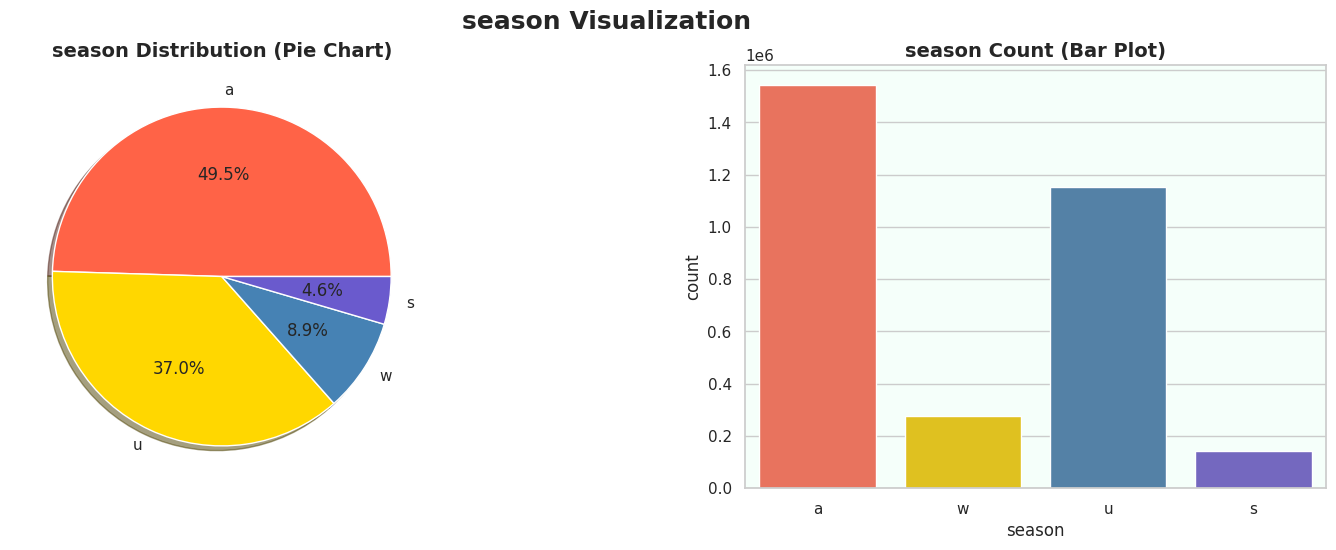

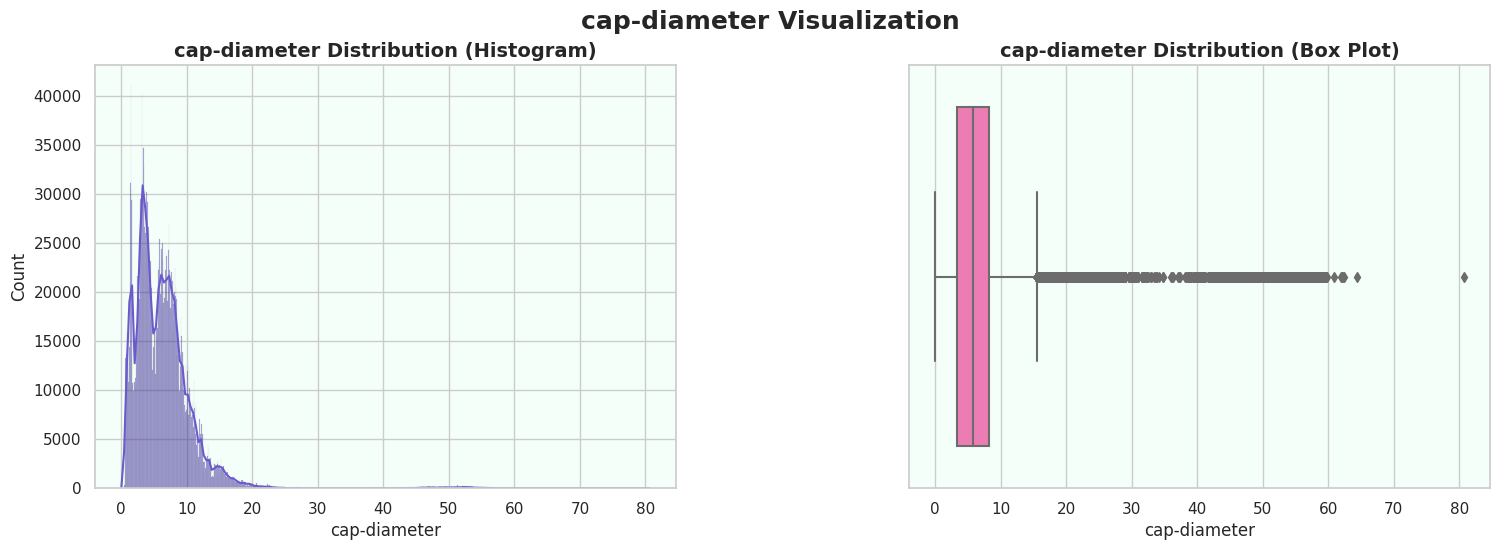

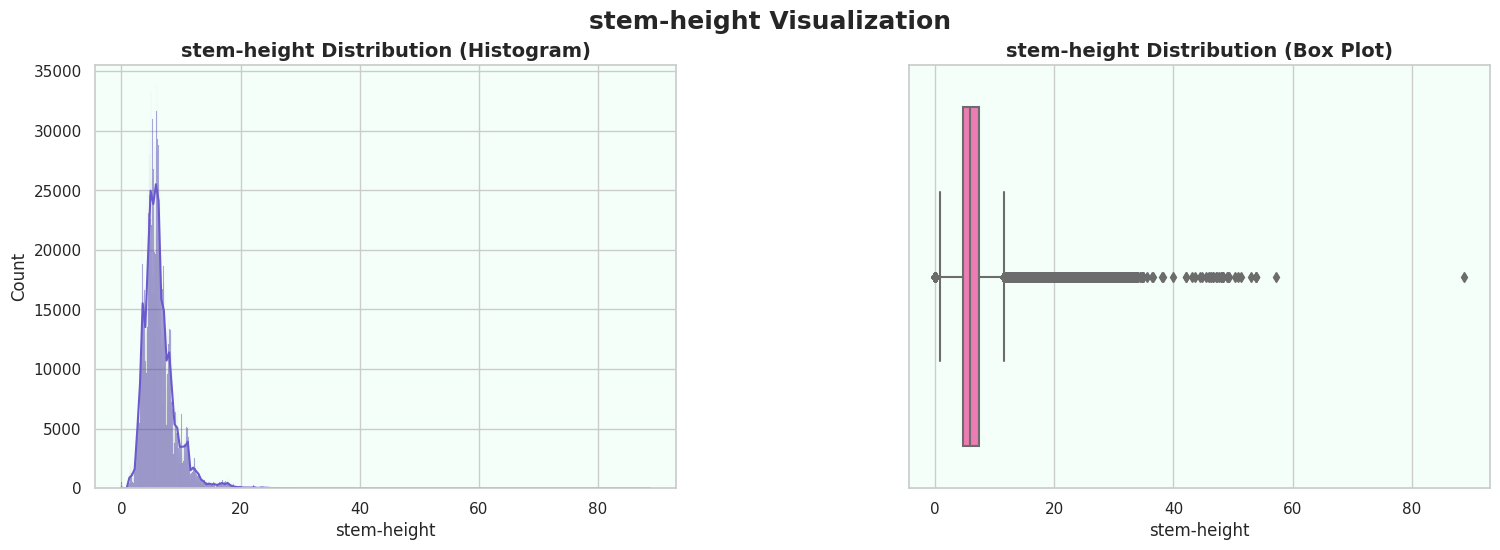

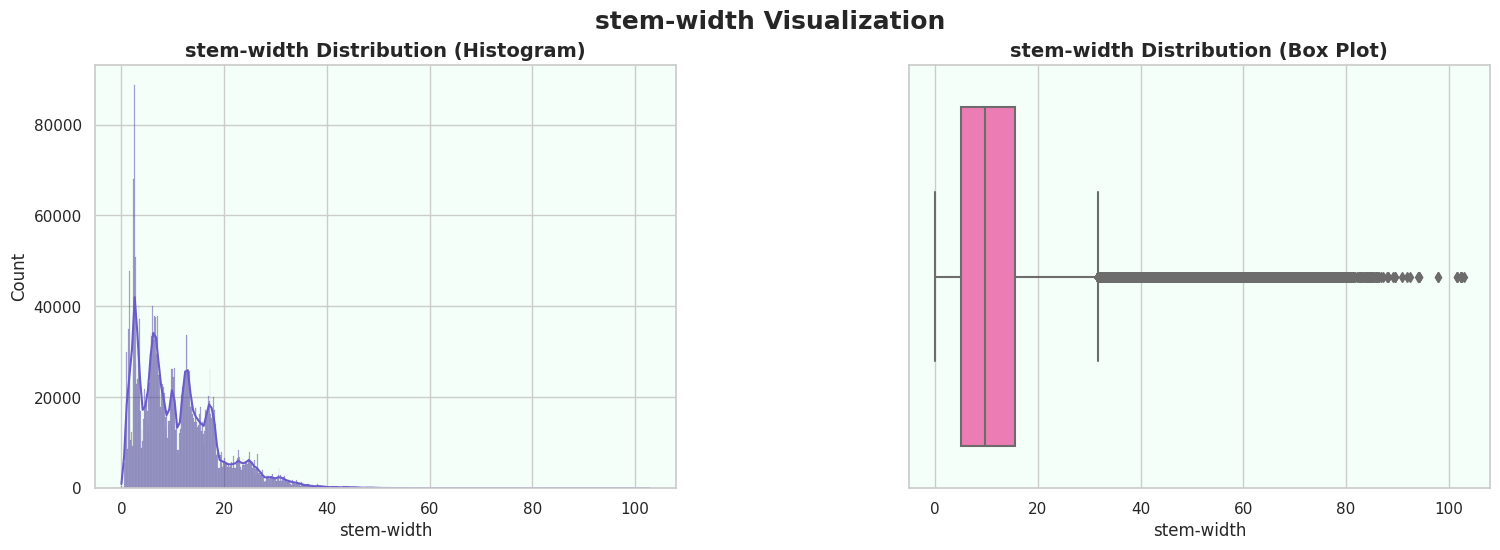

In [10]:
# Custom color palette for mushroom-related visuals
custom_palette = sns.color_palette(['#FF6347', '#FFD700', '#4682B4', '#6A5ACD', '#40E0D0', '#FF69B4', '#B0C4DE'])

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Visualize Categorical Variables
for column in categorical_features:
    if train[column].nunique() <= 20:  # Only plot pie charts for features with <= 20 unique values
        f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
        train[column].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, colors=custom_palette)
        ax[0].set_ylabel('')
        ax[0].set_title(f'{column} Distribution (Pie Chart)', fontsize=14, fontweight='bold')
        ax[0].set_facecolor('#F5FFFA')  # Set background color for better contrast
        sns.countplot(x=column, data=train, ax=ax[1], palette=custom_palette)
        ax[1].set_title(f'{column} Count (Bar Plot)', fontsize=14, fontweight='bold')
        ax[1].set_facecolor('#F5FFFA')
        plt.suptitle(f'{column} Visualization', fontsize=18, fontweight='bold')
        plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
        plt.show()
    else:  # For columns with more unique values, use only bar plot
        plt.figure(figsize=(18, 6))
        sns.countplot(x=column, data=train, palette=custom_palette, order=train[column].value_counts().index)
        plt.title(f'{column} Count (Bar Plot)', fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.gca().set_facecolor('#F5FFFA')
        plt.show()

# Visualize Numerical Variables
for column in numerical_features:
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
    sns.histplot(train[column], ax=ax[0], kde=True, color=custom_palette[3], edgecolor='black')
    sns.boxplot(x=train[column], ax=ax[1], color=custom_palette[5])
    ax[0].set_title(f'{column} Distribution (Histogram)', fontsize=14, fontweight='bold')
    ax[1].set_title(f'{column} Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax[0].set_facecolor('#F5FFFA')
    ax[1].set_facecolor('#F5FFFA')
    plt.suptitle(f'{column} Visualization', fontsize=18, fontweight='bold')
    plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
    plt.show()

# Create DataFrames for numerical and categorical variables
df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

## SEARCHING FOR MISSING VALUES


In [11]:
train.isna().sum()

class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

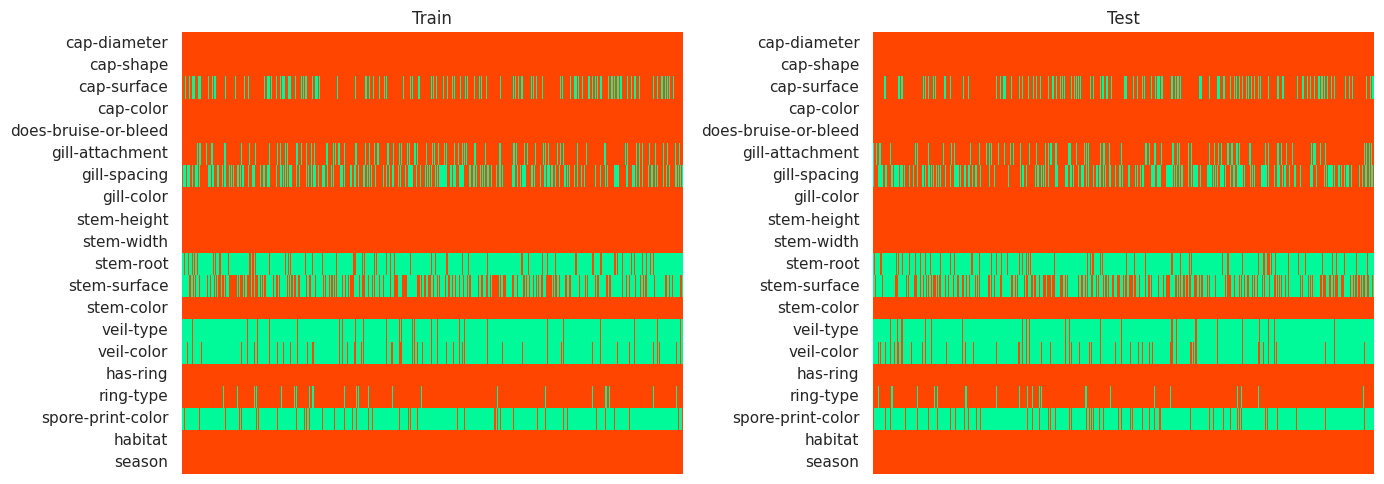

In [12]:
# Custom color palette
custom_palette = ['#FF4500', '#32CD32', '#1E90FF', '#FFD700', '#4B0082', '#FF1493', '#00FA9A']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['class']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [13]:
features = train.drop('class', axis=1).columns.to_list()

features_with_high_null_values = [feature for feature in features if (train[feature].isna().sum()/len(train)*100)>20]
df_features_high_null = pd.DataFrame(features_with_high_null_values, columns=['Features With High Null Values'])

# Apply styling to the DataFrame
df_features_high_null = style_dataframe(df_features_high_null)

# Display the styled DataFrame
df_features_high_null

Features With High Null Values
cap-surface
gill-spacing
stem-root
stem-surface
veil-type
veil-color
spore-print-color


## FEATURE ENGINERING

In [14]:
cat_features = test.select_dtypes('object').columns

In [15]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
for feature in cat_features:          
    categories = sorted(list(set(original[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan
    
    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)


## MODEL TRAINING AND OPTIMIZATION

In this section, we develop an ensemble model that integrates XGBoost (XGB) and LightGBM (LGBM) algorithms to predict outcomes based on our dataset. We perform hyperparameter optimization to fine-tune the model and enhance its performance. Following the training process, we generate predictions and format the results for submission, ensuring that the predictions are precise and properly structured for evaluation.


In [16]:
X = train.drop([TARGET], axis=1)
y = train[TARGET].map({'e': 0, 'p': 1})
X_test = test


## MEMORY OPTIMIZATION


In [17]:
def reduce_memory_usage(dataframe):        
    print('Reducing memory usage')
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            continue

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            dataframe[col] = dataframe[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            dataframe[col] = dataframe[col].astype(np.float32)
        else:
            dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [18]:
X = reduce_memory_usage(X)
X_test = reduce_memory_usage(X_test)

Reducing memory usage
--- Memory usage before: 210.16 MB
--- Memory usage after: 156.65 MB
--- Decreased memory usage by 25.5%

Reducing memory usage
--- Memory usage before: 97.11 MB
--- Memory usage after: 61.44 MB
--- Decreased memory usage by 36.7%




## MODEL TRAINING

In [19]:
def mcc(y_true, y_pred):
    y_pred_binary = np.round(y_pred) 
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    return 'MCC', mcc, True 

In [20]:
class Trainer:
    def __init__(self, models, n_folds=N_FOLDS):
        self.models = models  # List of models
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training ensemble of {len(self.models)} models\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            fold_oof_pred_probs = np.zeros((len(val_idx), len(np.unique(y))))
            fold_test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
            
            for model in self.models:
                model_instance = clone(model)
                
                # Fit the XGBoost model with verbose
                if isinstance(model_instance, XGBClassifier):
                    model_instance.fit(
                        X_train, 
                        y_train, 
                        eval_set=[(X_val, y_val)],
                        verbose=ES_LOG_STEPS
                    )
                
                # Fit the LGBM model with callbacks for verbosity and early stopping
                elif isinstance(model_instance, LGBMClassifier):
                    model_instance.fit(
                        X_train, 
                        y_train, 
                        eval_set=[(X_val, y_val)], 
                        eval_metric=mcc,
                        callbacks=[
                            log_evaluation(period=ES_LOG_STEPS), 
                            early_stopping(stopping_rounds=ES_ROUNDS, verbose=True)
                        ]
                    )
                
                # Predictions
                y_pred_probs = model_instance.predict_proba(X_val)
                fold_oof_pred_probs += y_pred_probs / len(self.models)  # Averaging predictions
                
                temp_test_pred_probs = model_instance.predict_proba(X_test)
                fold_test_pred_probs += temp_test_pred_probs / len(self.models)  # Averaging test predictions

                del model_instance, y_pred_probs, temp_test_pred_probs
                gc.collect()

            oof_pred_probs[val_idx] = fold_oof_pred_probs
            test_pred_probs += fold_test_pred_probs / self.n_folds  # Averaging across folds
            
            y_preds = fold_oof_pred_probs[:, 1] >= THRESHOLD
            score = matthews_corrcoef(y_val, y_preds)
            scores.append(score)
            
            print(f'\n--- Fold {fold_idx + 1} - MCC: {score:.6f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        print(f'------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')

    # Saving Predictions        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_names = "_".join([model.__class__.__name__.lower().replace('classifier', '') for model in self.models])
        with open(f'{model_names}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)

    # Saving Submission    
    def _save_submission(self, test_pred_probs, score):
        model_names = "_".join([model.__class__.__name__.lower().replace('classifier', '') for model in self.models])
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        
        subm = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        subm[TARGET] = test_pred_probs[:, 1] >= THRESHOLD
        subm[TARGET] = subm[TARGET].map({False: 'e', True: 'p'})
        S = subm[TARGET].ravel()

        #Ensemble Solution
        
        S1 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[TARGET].ravel()
        S2 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[TARGET].ravel()
        S3 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[TARGET].ravel()
        S4 = pd.read_csv("/kaggle/input/0-98530-can-you-eat/submission.csv")[TARGET].ravel()
        S5 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[TARGET].ravel()
        S6 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[TARGET].ravel()
        preds = [S, S1, S2, S3, S4,S5,S6]
        
        # Label encode the predictions
        lab_enc = LabelEncoder()
        # Fit the encoder on the unique classes 'e' and 'p'
        lab_enc.fit(['e', 'p'])
        
        # Encode each set of predictions
        encoded_preds = [lab_enc.transform(pred) for pred in preds]

        # Convert encoded_preds to a numpy array for easier processing
        encoded_preds = np.array(encoded_preds)

        # Get the mode along the columns (axis=0)
        mode_preds = mode(encoded_preds, axis=0)[0].ravel()  # This gives the most common prediction

        # Decode the numerical labels back to 'e' and 'p'
        sub[TARGET] = lab_enc.inverse_transform(mode_preds)
        
        sub.to_csv(f'sub_{model_names}_{score:.6f}.csv', index=False)

In [21]:
# xgb_params = {
#     "colsample_bylevel": 0.9268202748354142,
#     "colsample_bynode": 0.9584021138317574,
#     "colsample_bytree": 0.5015612007146208,
#     "early_stopping_rounds": ES_ROUNDS,  
#     "enable_categorical": True,
#     "gamma": 0.3707206931090372,
#     "grow_policy": "lossguide",
#     "learning_rate": 0.03906159386409017,
#     "max_depth": 16,
#     "min_child_weight": 0.6117236350232369,
#     "n_estimators": 5000,
#     "n_jobs": -1,
#     "random_state": SEED,
#     "reg_alpha": 1.7264475728199302,
#     "reg_lambda": 94.37990118781973,
#     "subsample": 0.7599216762241778,
#     "tree_method": "hist",
#     "verbosity": 0
# }

# lgbm_params = {
    
#     'colsample_bytree': 0.49938653455911297,
#     'learning_rate': 0.019616165942899312,
#     'max_bin': 2249,
#     'min_child_samples': 156,
#     'n_estimators': 5000,
#     'n_jobs': -1,
#     'num_leaves': 590,
#     'random_state': SEED,
#     'reg_alpha': 0.416272935775317,
#     'reg_lambda': 86.59005784540076,
#     'subsample': 0.7495711298182588,
#     'verbose': -1
# }

xgb_params = {
    "colsample_bylevel": 0.9268202748354142,
    "colsample_bynode": 0.9584021138317574,
    "colsample_bytree": 0.5015612007146208,
    "early_stopping_rounds": 13,  # Starting point for optimal early stopping
    "enable_categorical": True,
    "gamma": 0.3707206931090372,
    "grow_policy": "lossguide",
    "learning_rate": 0.03906159386409017,
    "max_depth": 16,
    "min_child_weight": 0.6117236350232369,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 1.7264475728199302,
    "reg_lambda": 94.37990118781973,
    "subsample": 0.7599216762241778,
    "tree_method": "hist",
    "verbosity": 0
}

lgbm_params = {
    'colsample_bytree': 0.49938653455911297,
    'learning_rate': 0.019616165942899312,
    'max_bin': 2249,
    'min_child_samples': 156,
    'n_estimators': 5000,
    'n_jobs': -1,
    'num_leaves': 590,
    'random_state': SEED,
    'reg_alpha': 0.416272935775317,
    'reg_lambda': 86.59005784540076,
    'subsample': 0.7495711298182588,
    'verbose': -1,
    'early_stopping_rounds': 13  # Starting point for optimal early stopping
}


xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)

# Create the trainer with both models
trainer = Trainer(models=[xgb_model, lgbm_model])

# Train and predict
trainer.fit_predict(X, y, X_test)

Training ensemble of 2 models

[0]	validation_0-logloss:0.65499
[100]	validation_0-logloss:0.05335
[200]	validation_0-logloss:0.03784
[300]	validation_0-logloss:0.03651
[400]	validation_0-logloss:0.03616
[500]	validation_0-logloss:0.03601
[600]	validation_0-logloss:0.03592
[700]	validation_0-logloss:0.03588
[800]	validation_0-logloss:0.03585
[878]	validation_0-logloss:0.03584
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.12255	valid_0's MCC: 0.982643

--- Fold 1 - MCC: 0.984409


[0]	validation_0-logloss:0.65490
[100]	validation_0-logloss:0.05250
[200]	validation_0-logloss:0.03724
[300]	validation_0-logloss:0.03594
[400]	validation_0-logloss:0.03561
[500]	validation_0-logloss:0.03547
[600]	validation_0-logloss:0.03539
[700]	validation_0-logloss:0.03533
[800]	validation_0-logloss:0.03530
[858]	validation_0-logloss:0.03530
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.122432	valid_0's MCC: